## Clock Classification
### The dataset contains 144 classes of clocks. All 12 Hours with all multiple of 5 minutes are included (which are the 12 clock patterns).
### Datset: https://www.kaggle.com/datasets/gpiosenka/time-image-datasetclassification/data
### This notebook is used to train a model for clock classification using VGG19 base model and Nadam optimizer, with a little tweaking and hypertuning in order to extract a more accurate model.
##### Data: Clocks
##### Model: VGG19
##### Optimizer: Nadam
##### Epochs: 60
##### Batch Size: 32

## Importing libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import VGG19

## Loading data

In [13]:
# make data generator for training, validation, and testing
Generator = ImageDataGenerator(rescale=1./255)
train_G = Generator.flow_from_directory('train', target_size=(128, 128), batch_size=128, class_mode='categorical', shuffle=True)
test_G = Generator.flow_from_directory('test', target_size=(128, 128), batch_size=128, class_mode='categorical', shuffle=True)
valid_G = Generator.flow_from_directory('valid', target_size=(128, 128), batch_size=128, class_mode='categorical', shuffle=True)


Found 11520 images belonging to 144 classes.
Found 1440 images belonging to 144 classes.
Found 1440 images belonging to 144 classes.


In [14]:
# Load the CSV file with label meanings
df = pd.read_csv('clocks.csv')
df

,class index,filepaths,labels,data set
0,0,train/1-00/0.jpg,1_00,train
1,0,train/1-00/1.jpg,1_00,train
2,0,train/1-00/11.jpg,1_00,train
3,0,train/1-00/12.jpg,1_00,train
4,0,train/1-00/13.jpg,1_00,train
...,...,...,...,...
14395,143,valid/9-55/65.jpg,9_55,valid
14396,143,valid/9-55/74.jpg,9_55,valid
14397,143,valid/9-55/88.jpg,9_55,valid
14398,143,valid/9-55/90.jpg,9_55,valid


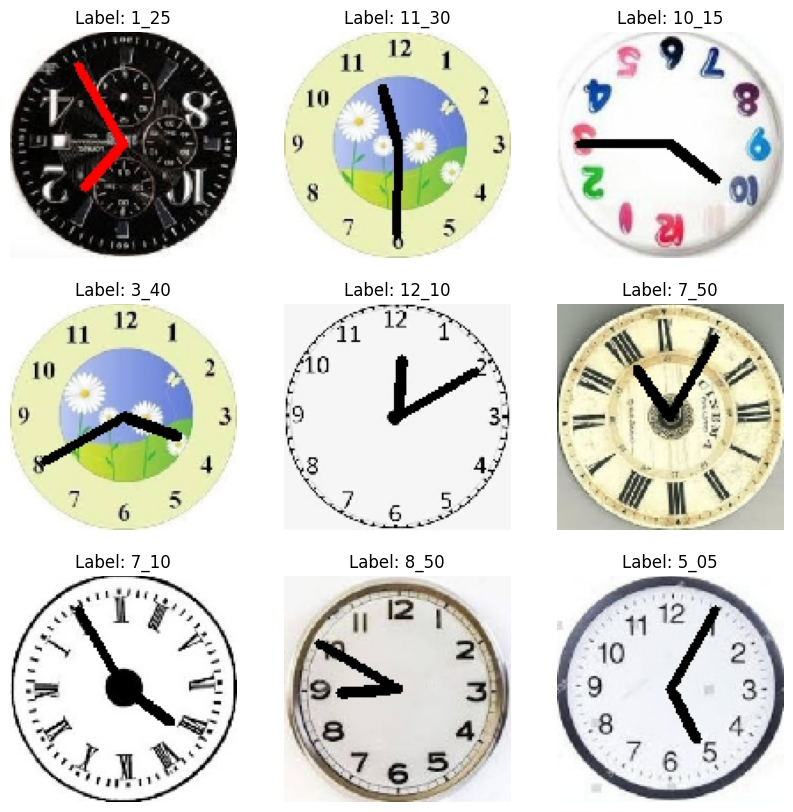

In [15]:
# Plot the first 9 images in the training set and their labels
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    ax[i//3, i%3].imshow(train_G[0][0][i])
    ax[i//3, i%3].axis('off')
    
    # Use argmax to get the index of the maximum value in the label array
    label_index = np.argmax(train_G[0][1][i])
    
    # Look up the corresponding label meaning from the CSV file
    label_meaning = df.loc[df['class index'] == label_index, 'labels'].values[0]
    
    # Display the label meaning as the title
    ax[i//3, i%3].set_title(f'Label: {label_meaning}')

## Creating the model

In [16]:
# setting policy for my gpu
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [17]:
# VGG19 base model
base = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# print out the base model layers
base.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [18]:
# with help from "Avantika" idea of freezing the last 4 layers: https://www.kaggle.com/code/avantikab/time-image-classification-with-vgg16?scriptVersionId=120171598&cellId=17
# Freezing the base model
for layer in base.layers[:-4]:
    layer.trainable = False

In [19]:
# Specify the input layer
input = Input(shape=(128, 128, 3))
# Adding the base model
x = base(input)
x = Dropout(0.4)(x)
# Adding Batch Normalization layer for VGG19
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
# Adding Global Average Pooling layer for VGG19
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
# Adding a dense layer with 1024 neurons and ReLU activation along with Batch Normalization, Dropout, and L2 regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
# Adding output layer
output = Dense(144, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Dropout, Batch Normalization, and L2 are all regularization techniques used to prevent overfitting

In [20]:
# Creating our clock final model
clock = Model(input, output)
# Using Nadam optimizer
clock.compile(optimizer=Nadam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])
# Showing the summary of the model
clock.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 dropout_5 (Dropout)         (None, 4, 4, 512)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 4, 4, 512)         0         
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                  

#### Let's train our model

In [22]:
clock_history = clock.fit(train_G, epochs=60, validation_data=test_G, batch_size=32)

Epoch 1/60
90/90 [==============================] - 56s 594ms/step - loss: 9.0512 - accuracy: 0.0072 - val_loss: 7.7631 - val_accuracy: 0.0090
Epoch 2/60
90/90 [==============================] - 51s 564ms/step - loss: 8.0499 - accuracy: 0.0150 - val_loss: 6.8635 - val_accuracy: 0.0354
Epoch 3/60
90/90 [==============================] - 49s 543ms/step - loss: 6.8187 - accuracy: 0.0443 - val_loss: 5.9329 - val_accuracy: 0.1160
Epoch 4/60
90/90 [==============================] - 49s 543ms/step - loss: 5.6603 - accuracy: 0.1156 - val_loss: 4.9477 - val_accuracy: 0.2625
Epoch 5/60
90/90 [==============================] - 49s 544ms/step - loss: 4.7535 - accuracy: 0.2041 - val_loss: 4.2158 - val_accuracy: 0.3833
Epoch 6/60
90/90 [==============================] - 51s 563ms/step - loss: 4.0651 - accuracy: 0.3091 - val_loss: 3.8668 - val_accuracy: 0.4299
Epoch 7/60
90/90 [==============================] - 49s 543ms/step - loss: 3.5300 - accuracy: 0.4069 - val_loss: 3.3999 - val_accuracy: 0.5500

#### Model Evaluation

In [23]:
clock.evaluate(valid_G)

12/12 [==============================] - 7s 597ms/step - loss: 0.3203 - accuracy: 0.9715


[0.32030895352363586, 0.9715277552604675]

#### Our Accuracy is 97.15%

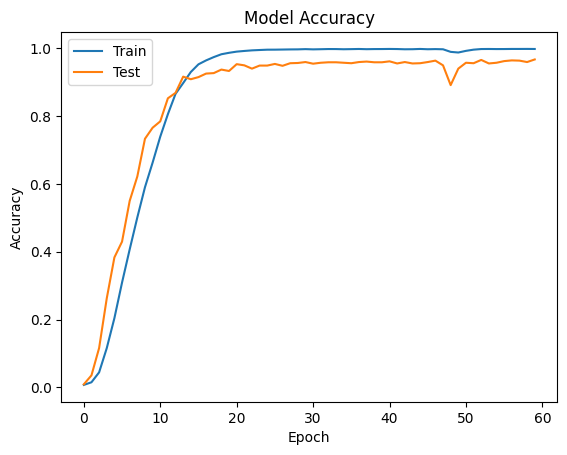

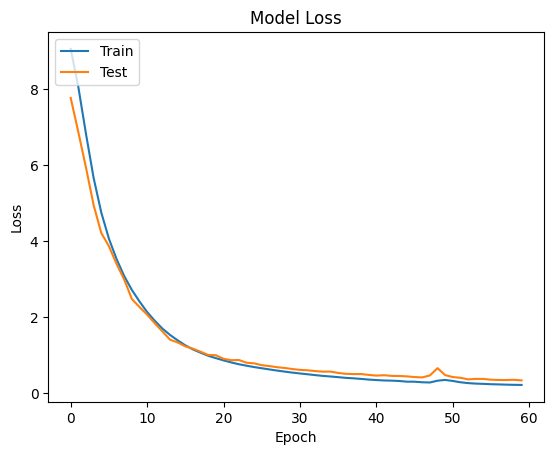

In [24]:
# Plot the curve of accuracy and loss
plt.plot(clock_history.history['accuracy'])
plt.plot(clock_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(clock_history.history['loss'])
plt.plot(clock_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


#### Saving Our Model

In [27]:
clock.save('VGG19_clock_Nadam_97.15.h5')